## Environment Setup
For Colab, the helper folders need to be copied over from the repo. The below cell does this automatically.

In [ ]:
%%bash

# Check if the environment variable exists
if [ -n "$COLAB_RELEASE_TAG" ] || [ -n "$COLAB_GPU" ]; then
    echo "Running on Google Colab. Cloning repository into temp folder..."
    git clone https://github.com/TuebingenAICenter/agent-tutorial.git /tmp/tmp_repo
    echo "Moving all helpers to project root..."
    mv /tmp/tmp_repo/chat_with_X_utils .
    mv /tmp/tmp_repo/images .
    mv /tmp/tmp_repo/hello-mcp .
    mv /tmp/tmp_repo/env.example ./.env
    mv /tmp/tmp_repo/requirements.txt .
else
    echo "Not running on Google Colab. Skipping git clone."
fi

# The installation block runs regardless of environment.
echo "Checking for requirements.txt and installing required packages..."

# Check if requirements.txt exists in the current directory
if [ -f "requirements.txt" ]; then
    # Attempt to install with 'uv', and if it fails (exit code != 0), use 'pip' as a fallback.
    if command -v uv &> /dev/null; then
        echo "uv detected. Installing with uv..."
        uv pip install -r requirements.txt
    else
        echo "Installing with pip..."
        pip install -r requirements.txt
    fi
else
    echo "ERROR! requirements.txt not found! Please check for errors..."
fi

### Setting API Keys

In [ ]:
import dotenv
import os
from getpass import getpass

# Load environment variables from a .env file if it exists
dotenv.load_dotenv()

# Prompt for the API key if it's not already set
for var in ["OPENROUTER_API_KEY"]:
    if  var not in os.environ:
            os.environ[var] = getpass(
                f"Enter your {var.replace('_', ' ')}: "
            )
            
if not os.environ["OPENROUTER_API_KEY"]:
    print("WARNING: API key not set.")


TAVILY_API_KEY = os.getenv("TAVILY_API_KEY", "")
if not TAVILY_API_KEY:
    print("INFO: TAVILY_API_KEY not set; web search tool will be disabled.")
else:
    HAS_TAVILY = True
    try:
        from tavily import TavilyClient
        tavily = TavilyClient(api_key=TAVILY_API_KEY)
    except Exception:
        HAS_TAVILY = False

# LangGraph + MCP Deep-Research Agent

Let's integrate everything we've seen so far into a final example: Deep Research Agent

**What:** example to show how to

- use MCP tools in LangGraph

- scale up orchestration/architecture complexity

**Why:** Gives you all the necessary information you need to build agents of such scales yourself *including* MCP

**Live:** Follow along and fill in some key lines for the main lessons: `Send` API, Structured Outputs, passing in arguments through the configurable.

## What we plan to create

<img src="./images/Agent_03_diagram.png">

## What it looks like in LangGraph

<img src="./images/Agent_03_lg.png">

## Setup

In [ ]:
# Imports and helpers
from typing import TypedDict, Annotated, List, Dict, Optional
import pathlib as _pl
import re as _re
from operator import add as _list_add
import asyncio


from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, BaseMessage, ToolMessage
from langchain_core.rate_limiters import InMemoryRateLimiter 
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool
from langchain_mcp_adapters.client import MultiServerMCPClient
from langchain_mcp_adapters.tools import load_mcp_tools
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langgraph.types import Send

from pydantic import BaseModel, Field 

# Local utils
# Ensure we pick up latest print utils implementation
import importlib as _imp
import chat_with_X_utils.print_utils as _print_utils_mod
_imp.reload(_print_utils_mod)
from chat_with_X_utils.print_utils import (
    print_messages_from_stream_event as _print_messages_from_stream_event,
    print_messages_from_state as _print_messages_from_state,
)

### Logging utils

In [49]:
# Output paths
OUTPUT_DIR = _pl.Path("research_output")
SUBAGENTS_DIR = OUTPUT_DIR / "subagents"


def _slugify(text: str) -> str:
    text = _re.sub(r"[^a-zA-Z0-9\-_. ]+", " ", text).strip().lower()
    text = _re.sub(r"\s+", "-", text)
    return text[:80] or "item"

def _ensure_dirs():
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    SUBAGENTS_DIR.mkdir(parents=True, exist_ok=True)

def _pretty_messages_trace(messages: List[BaseMessage]) -> str:
    lines: List[str] = []
    for m in messages or []:
        role = m.__class__.__name__.replace("Message", "").upper()
        # Decorate tool message role with tool name if available
        if isinstance(m, ToolMessage):
            tool_name = getattr(m, "name", "") or getattr(m, "tool_name", "") or ""
            role = f"TOOL[{tool_name}]"
        # Summarize tool calls from assistant turns
        if isinstance(m, AIMessage) and getattr(m, "tool_calls", None):
            for i, tc in enumerate(m.tool_calls, 1):
                try:
                    name = getattr(tc, "name", None) or (tc.get("name") if isinstance(tc, dict) else "")
                except Exception:
                    name = ""
                try:
                    args = getattr(tc, "args", None) or (tc.get("args") if isinstance(tc, dict) else {})
                except Exception:
                    args = {}
                lines.append(f"{role} tool_call[{i}]: {name} args={args}")
        content = getattr(m, "content", "")
        if content:
            lines.append(f"{role}: {content}")
    return "\n".join(lines)
def _extract_subquestion_from_composed(text: str) -> str:
    """Extract only the sub-question from a composed question string.

    Expected composed format: "Main question: ...\nSub-question: ..."
    Falls back to the full text if no sub-question marker is found.
    """
    if not isinstance(text, str) or not text:
        return ""
    # Try strict line-based parse first
    for line in text.splitlines():
        if line.strip().lower().startswith("sub-question:"):
            return line.split(":", 1)[-1].strip()
    # Fallback: regex anywhere
    m = _re.search(r"Sub-question:\s*(.+)", text, flags=_re.IGNORECASE | _re.DOTALL)
    if m:
        return m.group(1).strip()
    return text.strip()

def _subagent_log_path(question: str) -> _pl.Path:  # type: ignore[override]
    """Return the log file path for a sub-agent using only the sub-question (no timestamp)."""
    sub_q = _extract_subquestion_from_composed(question)
    slug = _slugify(sub_q)[:60]
    return SUBAGENTS_DIR / f"{slug}.log"

### Clearing the logs before another run

In [50]:
import shutil as _sh
try:
    if OUTPUT_DIR.exists():
        _sh.rmtree(OUTPUT_DIR)
    _ensure_dirs()
    print(f"Cleared and recreated output folder: {OUTPUT_DIR.resolve()}")
except Exception as e:
    print(f"WARN: Failed to reset output folder: {e}")

Cleared and recreated output folder: /home/linus/git/agent-tutorial-dev/research_output


### Setting up language models

In [ ]:
# LLM config

# Rate limiting: define per-model in-memory limiters
# 4.1 and 4.1-mini both allow up to 500 requests per minute (RPM). We enforce a lower bound to account for TKM limits as well.
RPS_41 = 500 / 120.0
RPS_41_MINI = 500 / 60.0  # higher TPM applies to token budgets, not requests.
_RATE_CHECK_EVERY = 0.1  # seconds
_BURST = 10  # allow short bursts; adjust to taste

limiter_41 = InMemoryRateLimiter(requests_per_second=RPS_41, check_every_n_seconds=_RATE_CHECK_EVERY, max_bucket_size=_BURST)
limiter_41_mini = InMemoryRateLimiter(requests_per_second=RPS_41_MINI, check_every_n_seconds=_RATE_CHECK_EVERY, max_bucket_size=_BURST)

llm = ChatOpenAI(
    model="gpt-4.1-mini-2025-04-14",
    temperature=0.0,
    base_url="https://openrouter.ai/api/v1",
    api_key=os.environ["OPENROUTER_API_KEY"],
    rate_limiter=limiter_41_mini,  # enforce 500 RPM on the mini model
)

# Use a stronger model and bigger token budget for synthesis by default
synthesis_llm = ChatOpenAI(
    model="gpt-4.1-2025-04-14",
    temperature=0.2,
    base_url="https://openrouter.ai/api/v1",
    api_key=os.environ["OPENROUTER_API_KEY"],
    max_tokens=4000,
    rate_limiter=limiter_41,  # enforce 500 RPM on the 4.1 model
)



## Tools

### Langgraph Tool: web search [Optional]


In [ ]:
if HAS_TAVILY:
    @tool(parse_docstring=True)
    def web_search(query: str, max_results: int = 5) -> str:
        """Search the web with Tavily and return a compact digest of results.

        Args:
            query: Natural language query to search for on the web.
            max_results: Maximum number of results to include (default 5).

        Returns:
            A multi-line string listing result titles, URLs, and brief snippets.
        """
        try:
            data = tavily.search(query=query, max_results=max_results)
            items = data.get("results", [])
            if not items:
                return "No results found."
            lines = []
            for i, it in enumerate(items, 1):
                title = it.get("title", "")
                url = it.get("url", "")
                snippet = it.get("content", "")
                lines.append(f"[{i}] {title}\n{url}\n{snippet}\n")
            return "\n".join(lines)
        except Exception as e:
            return f"Web search error: {e}"
else:
    def web_search(*args, **kwargs):
        return "Web search disabled (no TAVILY_API_KEY)."

### MCP Tool: Filesystem RAG server

Langgraph provides a simple wrapper [`MultiServerMCPClient`](https://langchain-ai.github.io/langgraph/reference/mcp/) for integrating multiple MCP servers into workflows

In [ ]:
from chat_with_X_utils.async_mcp_helper import MCPManager

# Use the MCP server config from the previous session
server_name = "filesystem_rag"  
mcp_config = {
    server_name: {
      "command": "uv",
      "args": [
        "run",
        "./hello-mcp/filesystem_rag/server_solution.py",
        "--directory=/tmp/filesystem_rag/"
      ],
      "transport": "stdio"
    },
    # It's possible to define multiple servers here and connect to them by name
}

mcp_client = MultiServerMCPClient(mcp_config)

manager = MCPManager(mcp_client)

# Start the MCP session and load the tools into Langgraph Tools
session, rag_server_tools = await manager.start_session(server_name)

In [ ]:
rag_server_tools

## Sub-research agent

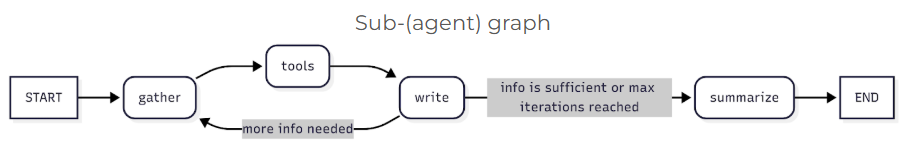

### [State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state)

The subresearcher state contains the following:
- The `sub-question` it should research.
- The `iteration` of research it is currently in, so that we can check against max_sub_iterations.
- The `sub_researcher_messages` for communication between all the LLM calls in our nodes.
- The `sub_reports` for handing the sub-researcher reports over to the supervisor. Note that this key needs to match the supervisors state and is thus is a list, which at the end of the sub-researcher call only contains a single element.

In [ ]:
from re import sub


class SubResearchState(TypedDict):
    question: str
    iteration: int
    sub_researcher_messages: Annotated[List[BaseMessage], add_messages]
    sub_reports: List[str]

### Nodes

We have the following nodes:
- `gather_context`: Prompts the LLM to gather context on the sub-question and provide the appropriate tool calls, this uses the llm with access to the tools. The prompt is slightly different depending on the iteration (first iteration vs later iterations). Writes the tool calls to the `sub_researcher_messages` state key.

- `tools`: A simple ToolNode containing the research tools. Writes the tool outputs to the `sub_researcher_messages` state key as context for the writer.

- `write_section`: Prompts the LLM to write a section based on the gathered context, this uses the llm without access to the tools. Writes the written section to the `sub_researcher_messages` state key. It also increments the `iteration` state key by 1.

- `summarize_answer`: Prompts the LLM to summarize the findings and provide a final answer to the sub-question, this uses the llm without access to the tools. Writes the final report to the `sub_reports` state key, which is a list in order to work with the supervisors reducer for the same key.


In [ ]:
# Build subgraph
sub_researcher_design_graph = StateGraph(SubResearchState)
sub_researcher_design_graph.add_node("gather", gather_context)
# TODO add a ToolNode called "tools" that uses RESEARCH_TOOLS and has the correct messages_key set for the sub-researcher messages
sub_researcher_design_graph.add_node...
sub_researcher_design_graph.add_node("write", write_section)
sub_researcher_design_graph.add_node("summarize", summarize_answer)

### Edges

The regular edges are:
- `START` -> `gather_context`
- `gather_context` -> `tools`
- `tools` -> `write_section`
- `summarize_answer` -> `END`

The conditional edge `router_after_write` utilizes a routing function to decide whether to go back to `gather_context` or proceed to `summarize_answer` based on:
1. The current iteration and the `max_sub_iterations` configurable parameter. If it exceeds the maximum, the function will route to `summarize_answer`.
2. An LLM based router that evaluates the completeness of the research conducted so far and decides whether more information is needed or if it's time to summarize the findings.

The router utilizes LangChain's [`with_structured_output` method with a pydantic class](https://python.langchain.com/docs/how_to/structured_output/#pydantic-class) with the pattern `^(more|enough)$` to ensure that the output matches the expected format and can be parsed correctly.

In [ ]:
# Model for structured output decision
class WriteRoutingDecision(BaseModel):
    """Decision after a write iteration: whether to gather more or summarize."""
    decision: str = Field(description="'more' to gather more; 'enough' to summarize", pattern="^(more|enough)$")

_write_decider = llm.with_structured_output(WriteRoutingDecision)

# Routing after writing: either gather more (loop to tools) or summarize
def route_after_write(state: SubResearchState, config: Dict):
    it = state.get("iteration", 0)
    sub_question = state.get("question", "")
    max_iter = config.get("configurable", {}).get("max_sub_iterations", 4)
    if it >= max_iter:
        return "summarize"

    judge_system = f"""
        You are a research completeness evaluator.

        Evaluate if the current research adequately addresses the sub-question.

        Return decision='more' if ANY of these are true:
        - Missing critical perspectives or stakeholders
        - Lack of quantitative data or specific examples
        - No discussion of limitations or potential failures
        - Insufficient evidence for main claims (< 3 citations for key points)
        - No recent sources (everything pre-2023) for contemporary topics
        - Missing implementation details or practical applications
        - No contradictory evidence or alternative viewpoints examined
        - Geographic or demographic gaps in coverage
        - Insufficient depth or mostly surface-level analysis

        Return decision='enough' if ALL of these are satisfied:
        - Multiple credible sources support each major claim
        - Both supporting and contradicting evidence examined
        - Specific examples, data points, or case studies included
        - Practical implications clearly explained
        - Reasonable depth achieved (600+ words of substantive content)
        - No major logical gaps in the argumentation
        - Diminishing returns likely from additional searches

        Sub-question: {sub_question}
        Completed iterations: {it}

        Answer only with the structured field 'decision'.
    """

    prior_messages = state.get("sub_researcher_messages", []) or []
    result = _write_decider.invoke([
        SystemMessage(content=judge_system),
        *prior_messages,
]) or None
    decision = (result.decision if result else "more").strip().lower()
    # TODO: Route to "gather" node if the decision is 'more' and "summarize" node if it's 'enough'
    return 

sub_researcher_design_graph.add_edge(START, "gather")
sub_researcher_design_graph.add_edge("gather", "tools")
sub_researcher_design_graph.add_edge("tools", "write")
sub_researcher_design_graph.add_conditional_edges(
    "write",
    route_after_write,
    ["gather", "summarize"],
)
sub_researcher_design_graph.add_edge("summarize", END)

# TODO: compile the sub-researcher design graph
sub_researcher_compiled_graph = sub_researcher_design_graph.compile()

## Supervisor agent

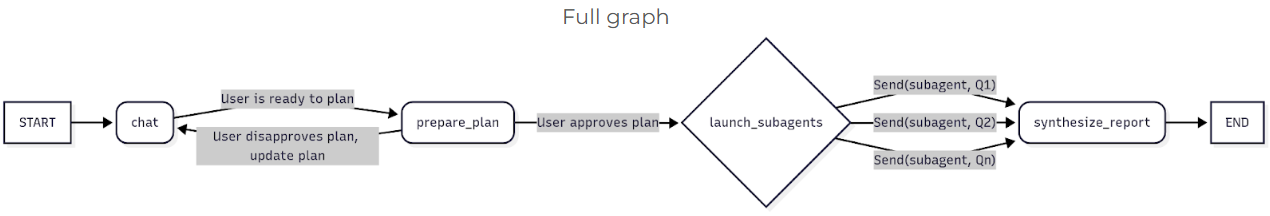

### State

The supervisor's state contains the following:
- The `supervisor_messages` for communication between all the LLM calls in our nodes.
- The `sub_questions` it fans out to the sub-researchers.
- The `sub_reports` for collecting the reports from the sub-researchers.

Note that we don't have a final answer state key, as that is directly written to the `research_report.md` file.

In [56]:
class SupervisorState(TypedDict):
    supervisor_messages: Annotated[List[BaseMessage], add_messages]
    sub_questions: List[str]
    sub_reports: Annotated[List[str], _list_add]

### Nodes

We have the following nodes:
- `supervisor_chat`: A simple chat node that co-develops the users question and associated sub-questions with the user. It writes the messages to the `supervisor_messages` state key.
- `prepare_plan`: Extracts the sub-questions from the chat and presents them to the user for approval. It writes the sub-questions to the `sub_questions` state key and writes the presentation to the `supervisor_messages` state key.
- `sub_researcher`: A subgraph node containing the sub-researcher agent described above. It takes in the `question` to research and writes the report to the `sub_reports` state key.
- `synthesize_report`: Prompts the LLM to synthesize the final report based on the collected sub-reports. It writes the final report to a `research_report.md` file and the anouncement that it has been written to the `supervisor_messages` state key.

The `prepare_plan` node uses the `with_structured_output` method to ensure a list is provided.

In [ ]:
class SubQuestionPlan(BaseModel):
    """Structured plan of sub-questions (and optional normalized main question)."""
    sub_questions: List[str] = Field(description="List of concrete sub-questions (up to the configured maximum)")

# TODO: bind the structured output model to the synthesis LLM
_plan_extractor = ...

def supervisor_chat(state: SupervisorState, config: RunnableConfig) -> Dict:
    previous_messages = state.get("supervisor_messages", [])

    max_sub_agents = config.get("configurable", {}).get("max_sub_agents", 4)

    chat_system = SystemMessage(
        content=(
            "You are the Supervisor research coordinator in PLANNING mode.\n"
            "- Co-develop the research plan with the user via clarifying questions.\n"
            "- Propose a set of detailed, specific sub-questions that fully decompose the main question.\n"
            f"- Respect the configured maximum: cap sub-questions at max_sub_agents={max_sub_agents}.\n"
            "- Ensure coverage across: current state, historical context, stakeholders, challenges, solutions, future trends, and edge cases.\n"
            "- Each sub-question must be answerable with evidence (not process steps), specific, and non-overlapping.\n"
            "- Do NOT draft any report content during planning; focus only on understanding requirements and shaping a comprehensive research plan.\n"
            "Quality: Aim for balanced coverage, minimal overlap, and actionable, evidence-focused questions."
            f"When proposing or listing sub-questions, you MUST cap the count at max_sub_agents={max_sub_agents} (i.e., return at most {max_sub_agents} distinct, evidence-focused sub-questions). Never exceed this limit."
    ))

    if not previous_messages:
        welcome = AIMessage(
            content=(
                "Hi! Describe your research question. I'll propose sub-questions and we iterate until you approve."
            )
        )
        return {"supervisor_messages": [welcome]}

    response = synthesis_llm.invoke([chat_system, *previous_messages])
    return {"supervisor_messages": [response]}


def prepare_plan(state: SupervisorState, config: RunnableConfig):
    previous_messages = state.get("supervisor_messages", [])

    max_sub_agents = config.get("configurable", {}).get("max_sub_agents", 4)

    # Node-specific system prompt for plan extraction
    instr = SystemMessage(
        content=(
            "Extract concrete sub-questions that fully cover the user's main question.\n"
            "Constraints:\n"
            f"- You MUST enforce max_sub_agents={max_sub_agents} — cap the number of sub-questions at {max_sub_agents}.\n"
            "- Avoid generic process steps; return only focused, evidence-answerable research questions.\n"
            "- Ensure coverage across: current state, historical context, stakeholders, challenges, solutions, future trends, and edge cases.\n"
            "- Reduce overlap and redundancy; prefer specificity and clarity.\n"
            "If more than the cap are plausible, prioritize those that maximize coverage and minimize overlap."
    ))
    result = _plan_extractor.invoke([instr, *previous_messages])
    subqs = [q.strip("- \n") for q in (result.sub_questions if result else []) if q and q.strip()]

    # Enforce the cap even if the model returns more
    subqs = subqs[:max_sub_agents]

    # Fallback to previous if extractor fails
    if not subqs:
        subqs = state.get("sub_questions", [])
    announce_list = "\n".join(f"- {q}" for q in subqs) or "(none)"
    preview = AIMessage(content=f"Planned sub-questions:\n{announce_list}")
    return {"sub_questions": subqs, "supervisor_messages": [preview]}

# LLM-based main-question extractor with fallback to latest HumanMessage

def synthesize_report(state: SupervisorState):
    _ensure_dirs()
    subreports = state.get("sub_reports", [])

    # Node-specific system prompt for synthesis
    synthesis_system = SystemMessage(
        content=(
            "You are the Supervisor research coordinator in SYNTHESIS mode.\n"
            "- Produce an extensive, authoritative final report (target 2500-4000+ words as needed).\n"
            "- Synthesize all sub-reports into a cohesive narrative; add executive-level analysis beyond simple combination.\n"
            "- Identify cross-cutting themes and insights; provide strategic recommendations based on evidence.\n"
            "- Maintain a professional tone and ensure factual consistency. Do NOT include citations or reference markers in the final report."
        )
    )

    prompt = (
        "<final_report>\n"
        "  <requirements>\n"
        "    <detail>Each section should contain multiple paragraphs where applicable. Do not include citations or reference markers (e.g., [1], [source_id]). Write self-contained prose.</detail>\n"
        "    <length>Target a comprehensive report; do not be terse.</length>\n"
        "    <style>Do not include planning steps, sub-questions, approval prompts, or meta-instructions. Output only the report. Begin with '# Final Report' and use Markdown headings (##, ###). No bold section titles.</style>\n"
        "    <limitations> Do not include citations or reference markers. Do not ask the user for clarifications instead of writing the report.</limitations>\n"
        "  </requirements>\n"
        "  <inputs>Sub-reports are provided below. Integrate, cross-check, and attribute contextually (no explicit citations).</inputs>\n"
        "</final_report>\n\n"
        "<sub_reports>\n" + ("\n\n".join(subreports) if subreports else "No sub-reports available.") + "\n</sub_reports>"
    )
    final = synthesis_llm.invoke([synthesis_system, HumanMessage(content=prompt)])
    final_text = getattr(final, "content", "")
    fname = OUTPUT_DIR / "research_report.md"
    with open(fname, "w", encoding="utf-8") as f:
        f.write(final_text)
    return {"supervisor_messages": [AIMessage(content=f"Final report written to {fname}")]} 

# Build Supervisor graph
supervisor_design_graph = StateGraph(SupervisorState)
supervisor_design_graph.add_node("chat", supervisor_chat)
supervisor_design_graph.add_node("prepare_plan", prepare_plan)
supervisor_design_graph.add_node("sub_researcher", sub_researcher_compiled_graph)
supervisor_design_graph.add_node("synthesize_report", synthesize_report)

### Edges

The regular edges are:
- `START` -> `supervisor_chat`
- `sub_researcher` -> `synthesize_report`
- `synthesize_report` -> `END`

The conditional edge `propose_or_wait` uses an LLM using `with_structured_output` with the `SupervisorDecision` pydantic class to decide whether to proceed to `prepare_plan` or to `END`, to continue the chat loop with the user, based on whether the user has accepted the proposed research plan.

The conditional edge `route_after_plan` uses an LLM using `with_structured_output` with the `PlanAcceptance` pydantic class to decide whether to proceed to `chat` or to `sub_researcher`, based on whether the user has accepted the proposed sub-questions or not. 
If the user has accepted the plan, it extracts the main questions from the chat messages using the `extract_main_question_llm` function as context for the sub-researchers. It then spawns a `sub_researcher` node for each sub-question using the `Send` action, passing in the sub-question as well as the extracted main question.

In [ ]:
class SupervisorDecision(BaseModel):
    """Router decision: should we spawn sub-researchers?"""
    action: str = Field(description="Decision to take", pattern="^(spawn|wait)$")

_decision_router = synthesis_llm.with_structured_output(SupervisorDecision)

class PlanAcceptance(BaseModel):
    """Whether the user has accepted the proposed plan."""
    accepted: bool = Field(description="True when the user approved proceeding with research")

_accept_judge = synthesis_llm.with_structured_output(PlanAcceptance)

class MainQuestion(BaseModel):
    """Single overarching main question extracted from chat."""
    main_question: str = Field(description="The user's main research question in one sentence")

_main_q_extractor = synthesis_llm.with_structured_output(MainQuestion)

def propose_or_wait(state: SupervisorState):
    previous_messages = state.get("supervisor_messages", [])
    system = SystemMessage(content=(
        "You are a concise decision router. Decide whether the user has approved the plan and is ready to start research.\n"
        "Return action='spawn' only if the conversation indicates explicit or implicit approval to proceed. Otherwise return action='wait'.")
)
    result = _decision_router.invoke([system, *previous_messages])
    action = (result.action if result else "wait")
    if action == "spawn":
        return "prepare_plan"
    return END

def extract_main_question_llm(messages: List[BaseMessage]) -> str:
    system = SystemMessage(content=(
        "From the conversation, extract the user's single overarching main research question in one sentence.\n"
        "If multiple are present, choose the most recent explicit user question.\n"
        "Do not include sub-questions, plan items, or meta-instructions. Return an empty string if unclear."
    ))
    try:
        result = _main_q_extractor.invoke([system, *messages])
        main_q = (result.main_question if result else "").strip()
    except Exception:
        main_q = ""
    return main_q

def route_after_plan(state: SupervisorState, config: Dict):
    previous_messages = state.get("supervisor_messages", [])

    last_human = None
    for m in reversed(previous_messages):
        if isinstance(m, HumanMessage):
            last_human = m
            break
    if last_human is None:
        return "chat"

    judge_instr = SystemMessage(content="""
        Decide if the user has accepted the proposed plan (explicit 'yes', 'approved', or clear consent).
        Return accepted=true only when it is reasonable to proceed; otherwise false.
        """,
    )
    accepted = False
    try:
        proposal_judgement = _accept_judge.invoke([judge_instr, last_human])
        accepted = bool(proposal_judgement.accepted if proposal_judgement else False)
    except Exception:
        accepted = False

    if not accepted:
        return "chat"

    subqs = state.get("sub_questions", [])
    if not subqs:
        return "chat"
    max_agents = config.get("configurable", {}).get("max_sub_agents", 4)
    subqs = subqs[:max_agents]

    main_q = extract_main_question_llm(previous_messages) or ""
    main_q_context = f"Main question: {main_q}\n" if main_q else ""

    # TODO: Send each sub-question with the main question context appended.
    return [Send("sub_researcher", {"question": f"{main_q_context}Sub-question: {q}"}) for q in subqs]

supervisor_design_graph = StateGraph(SupervisorState)
supervisor_design_graph.add_node("chat", supervisor_chat)
supervisor_design_graph.add_node("prepare_plan", prepare_plan)
supervisor_design_graph.add_node("sub_researcher", sub_researcher_compiled_graph)
supervisor_design_graph.add_node("synthesize_report", synthesize_report)

supervisor_design_graph.add_edge(START, "chat")
supervisor_design_graph.add_conditional_edges("chat", propose_or_wait, ["prepare_plan", END])
supervisor_design_graph.add_conditional_edges("prepare_plan", route_after_plan, ["chat", "sub_researcher"]) 
supervisor_design_graph.add_edge("sub_researcher", "synthesize_report")
supervisor_design_graph.add_edge("synthesize_report", END)

### Compile + Run

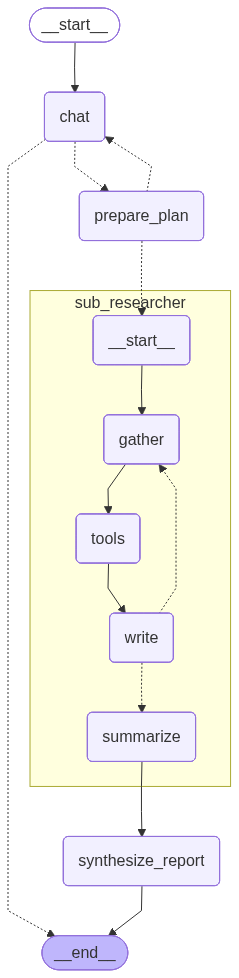

In [ ]:
# Compile + run
memory = MemorySaver()
full_compiled_graph = supervisor_design_graph.compile(checkpointer=memory, interrupt_before=["sub_researcher"])  # approve plan before launching subgraphs

try:
    from IPython.display import Image, display
    display(Image(full_compiled_graph.get_graph(xray=True).draw_mermaid_png())) # xray mode for displaying subgraph
except Exception:
    print("Mermaid rendering failed, trying ascii art")
    print(full_compiled_graph.get_graph(xray=True).print_ascii())

In [ ]:
# Minimal interactive loop
config = {"configurable": {"thread_id": "deepresearch_session_1", "max_sub_agents": 6, "max_sub_iterations": 4}}
_printed = set()

# Kick off with empty messages
initial = full_compiled_graph.invoke({"supervisor_messages": [], "sub_questions": [], "sub_reports": []}, config)
_print_messages_from_state(initial, _printed, messages_key="supervisor_messages")

while True:
    user = input("\nYou: ")
    if user.lower() in {"q", "quit", "exit"}:
        await manager.stop_all()
        break
    for event in full_compiled_graph.stream({"supervisor_messages": [HumanMessage(content=user)]}, config, stream_mode="values"):
        _print_messages_from_stream_event(event, _printed, messages_key="supervisor_messages")
    snapshot = full_compiled_graph.get_state(config)
    # Human gate: approve before launching sub-researchers
    while snapshot.next and snapshot.next[0] == "sub_researcher":
        ans = input("Approve the plan and launch sub-researchers? (y/N): ")
        if ans.strip().lower().startswith("y"):
            result = await full_compiled_graph.ainvoke(None, config)
            _print_messages_from_state(result, _printed, messages_key="supervisor_messages")
        else:
            denial = full_compiled_graph.invoke({"supervisor_messages": [HumanMessage(content="Not approved; please revise the sub-questions.")]}, config)
            _print_messages_from_state(denial, _printed, messages_key="supervisor_messages")
        snapshot = full_compiled_graph.get_state(config)

╭───────────────────────────────────────────────── 🤖 Assistant ──────────────────────────────────────────────────╮
│ Hi! Describe your research question. I'll propose sub-questions and we iterate until you approve.               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 👤 Human ────────────────────────────────────────────────────╮
│ What's deep learning?                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────── 🤖 Assistant ──────────────────────────────────────────────────╮
│ Thank you for your question! To ensure a thorough and actionable research plan, could you clarify your intended │
│ audience (e.g., technical experts, general public, students) and your main goal (e.g., overview, applications,  │
│ technical mechanisms, ethical concerns)? This will help tailor the sub-questions.                               │
│                                                                                                                 │
│ For now, here’s a draft set of sub-questions (capped at 6) that comprehensively address “What’s deep learning?” │
│ across key dimensions:                                                                                          │
│                                                                                                                 │
│ 1. What are the fundamental principles and defining characteristics of deep learning, and how does it differ    │
│ from traditional machine learning approaches?                                                                   │
│ 2. How did deep learning evolve historically, and what were the major milestones and breakthroughs that enabled │
│ its current prominence?                                                                                         │
│ 3. What are the primary architectures and algorithms used in deep learning, and what evidence supports their    │
│ effectiveness in various domains?                                                                               │
│ 4. Who are the main stakeholders involved in the development, deployment, and regulation of deep learning       │
│ technologies?                                                                                                   │
│ 5. What are the key challenges and limitations currently faced by deep learning, as evidenced by recent         │
│ research and real-world deployments?                                                                            │
│ 6. What emerging trends and future directions are anticipated for deep learning, based on current research and  │
│ expert forecasts?                                                                                               │
│                                                                                                                 │
│ Please let me know if you’d like to adjust the focus, add or remove any areas, or specify your audience or      │
│ application context!                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 👤 Human ────────────────────────────────────────────────────╮
│ No looks good but make only 3 sub research topics                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────── 🤖 Assistant ──────────────────────────────────────────────────╮
│ Great, thank you for the feedback! Here’s a revised research plan with only 3 focused, evidence-based           │
│ sub-questions:                                                                                                  │
│                                                                                                                 │
│ 1. What are the core principles and defining features of deep learning, and how does it differ from traditional │
│ machine learning methods?                                                                                       │
│ 2. What have been the most significant historical milestones and breakthroughs that contributed to the          │
│ development and widespread adoption of deep learning?                                                           │
│ 3. What are the main current challenges and limitations of deep learning, as demonstrated by recent research    │
│ and real-world applications?                                                                                    │
│                                                                                                                 │
│ Please confirm if this set meets your needs or if you’d like to adjust the focus further.                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 👤 Human ────────────────────────────────────────────────────╮
│ yyes                                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────── 🤖 Assistant ──────────────────────────────────────────────────╮
│ Thank you for confirming! Your research plan will proceed with the following three sub-questions:               │
│                                                                                                                 │
│ 1. What are the core principles and defining features of deep learning, and how does it differ from traditional │
│ machine learning methods?                                                                                       │
│ 2. What have been the most significant historical milestones and breakthroughs that contributed to the          │
│ development and widespread adoption of deep learning?                                                           │
│ 3. What are the main current challenges and limitations of deep learning, as demonstrated by recent research    │
│ and real-world applications?                                                                                    │
│                                                                                                                 │
│ If you have any additional preferences or requirements, please let me know before we move to the next phase.    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────── 🤖 Assistant ──────────────────────────────────────────────────╮
│ Planned sub-questions:                                                                                          │
│ - What are the core principles and defining features of deep learning, and how does it differ from traditional  │
│ machine learning methods?                                                                                       │
│ - What have been the most significant historical milestones and breakthroughs that contributed to the           │
│ development and widespread adoption of deep learning?                                                           │
│ - What are the main current challenges and limitations of deep learning, as demonstrated by recent research and │
│ real-world applications?                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────── 🤖 Assistant ──────────────────────────────────────────────────╮
│ Final report written to research_output/research_report.md                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯